<a href="https://colab.research.google.com/github/Jiaweihu08/Real-Time-NST/blob/master/RTNST_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Given two images ***Yc*** and ***Ys***, defined as content and style image accordingly, **Neural Style Transfer** is capable of producing a third image ***z*** that combines the content of ***Yc*** with the style of ***Ys***. Say that the content image is a day-to-day picture taken with a camera and the style image is a famous painting by a well-known artist such as Pablo Picasso,  Neural Style Transfer can output an image ***z*** that resembles a piece of artwork done by the same author displaying the content of your picture.

There has been a noticeable evolution in the way of performing Neural Style Transfer since [*Gatys et al*](https://arxiv.org/pdf/1508.06576.pdf) first introduced it in 2015. This baseline method of transforming style consists of repeatedly modifying a randomly initialized image(***z***) until its content is similar to the content image and the style in which it's being presented resembles the one from the style image. It requires computing the content difference between ***z*** and ***Yc*** and the style difference between ***z*** and ***Ys*** at each iteration, then use their gradients with respect to the pixels of ***z*** to modify it.

This method requires many iterations to obtain visually satisfying results. On 2016, the ideas proposed in ["***Perceptual Losses for Real-Time Style Transfer and Super-Resolution***"](https://arxiv.org/pdf/1508.06576.pdf) by Johnson et all allowed the construction of ***Image Transform Networks(ITN)*** to perform style transformation in real-time(even for camera captions) with no iterations involved. However, for each new style, a separate model must be trained.

To take one step further, the authors of ["***Exploring the structure of a real-time, arbitrary neural artistic stylization network***"](https://arxiv.org/pdf/1705.06830.pdf) were able to add another dimension of flexibility in style transfer by allowing its performance for any pair of content/style images in real-time.

This two-parted notebook is about exploring the first two above-mentioned methods for style transfer. The aim of ***part 1*** is to implement ***Style Transfer*** following the guideline set by [*Gatys et al*](https://arxiv.org/pdf/1508.06576.pdf). It closely follows [this Tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer), and its completion sure brought a deeper understanding of the practical side of Deep Learning. 

Aspects touched on were:
1. The implementation of ***Transfer Learning*** using TensorFlow and its high-level ***Keras*** API.
2. The construction of ***customized models***.
3. Customized training loops with Autodiff using ***tf.GradientTape()***.
4. Writing ***reusable code***.
5. Better understanding of ***TensorFlow 2.0***.

The ***Part 2*** is dedicated to an intent of training an ***Image Transform Networks*** from ["***Perceptual Losses for Real-Time Style Transfer and Super-Resolution***"](https://arxiv.org/pdf/1508.06576.pdf). Using the model architecture from [here](https://github.com/lengstrom/fast-style-transfer/blob/master/src/transform.py).

In [0]:
%tensorflow_version 2.x

import IPython
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from PIL import Image
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow_datasets as tfds

print(tf.__version__)

2.1.0


# - Part 1
### Neural Style Transfer

Let's first demonstrate the power of style transfer with an example. As shown in the outputs of the next cell, **Neural Style Transfer** is able to transform the style of a regular image, in this case of a cat, into the style of "*The Great Wave Off Kanagawa*":

The source of the images is shown in the cell.

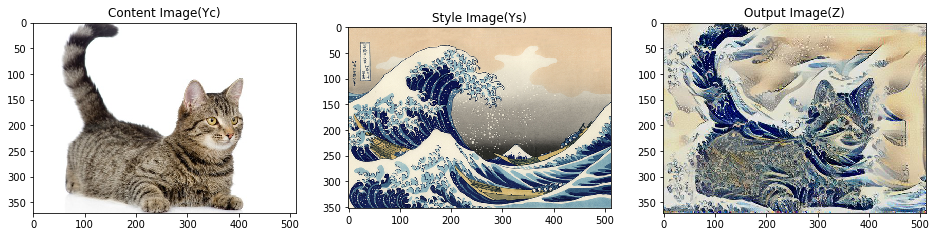

In [0]:
# Defining a couple of helper functions to load and show the images

def load_image(img_path, size=None):
    """" Input: img_path, path to an image
    Output: An image in array form

    This function loads an image from a given path
    and resizes it. The loaded image is turned into an array.
    The images will be arrays in RGB format(High, Width, Channels=3)
    and since the model to be used later on to obtain the intermediate
    representations requires a batch dimension, images' shape are turned
    into (batch_size, High, Width, Channels=3).
    """
    img = Image.open(img_path)
    if not size:
        scale = 512/max(img.size)
        img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)),
                         Image.ANTIALIAS)
    else:
        img = img.resize((size, size), Image.ANTIALIAS)
        
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0).astype('float32')
    return img

def imshow(img, title=None):
    """ Inputs:
            img, an image(numpy array)
            title, string
    Function to plot the images. matplotlib.pyplot.imshow()
    does not take the batch_size dimension of the image,
    it's eliminated using np.squeeze().
    """
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title:
        plt.title(title)

# Creating an image directory, downloading the style image and defining paths
img_dir = '/content/images/'
if not os.path.exists(img_dir):
   os.mkdir(img_dir)

!wget --quiet -P /content/images/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /content/images/ https://www.petmd.com/sites/default/files/what-does-it-mean-when-cat-wags-tail.jpg

style_path = '/content/images/The_Great_Wave_off_Kanagawa.jpg'
content_path = '/content/images/what-does-it-mean-when-cat-wags-tail.jpg'
result_path = '/content/images/result_image.jpg' # Image to be uploaded

# Displaying the images

plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
imshow(load_image(content_path), 'Content Image(Yc)')

plt.subplot(1,3,2)
imshow(load_image(style_path), 'Style Image(Ys)')

plt.subplot(1,3,3)
imshow(load_image(result_path), 'Output Image(Z)')

How It Works
- Convolutional Neural Networks

In order to understand the methodology behind it, first, we need to take look at Convolutional Neural Networks(CNN), and get a grasp on what it does.

As its own name indicates, the operation involved in a CNN layer is the one called convolutions. A **filter**, essentially a grid cell full of numbers, is being placed on the layer's input and it does element-wise multiplication of the overlapped area and sums all the results to obtain a single number. Starting from the upper-left corner(the inputs of a CNN layer usually has three dimensional: height, width, and the number of channels), the filter then moves one step to the right till the whole row is covered, the same process is repeated until the area of the input is entirely processed. The obtained values from this operation are placed in order to construct a **2D output**.

Filters are usually three-dimensional, having the same channel size as its inputs, its height and width are generally much smaller than the ones of its inputs. The size of the step taken by the filter is defined by a parameter called **strides**. It is also desired sometimes to **pad** the inputs for a number of reasons.

The output from each application with a single filter is always two-dimensional, different filters(always with the same size, strides, and padding but with different values) can be used and the number of which defines the channel size of the output. These filters generally have different values and it's up to the model to learn the best ones to minimize the loss function.

Now that's only a brief explanation on the technical side. But what can convolutions actually do? In simple terms, it captures features from its inputs. Say the input of a CNN layer is a greyscale image and the filter used has a shape of (3, 3, 1), with values equal to 0 except its central column being 1's. The output feature map produced by this filter would be similar to the original one except all the vertical lines are highlighted while the rest went blurry. By using a filter with 1's in its central row and the rest being 0, the horizontal lines will be enhanced while blurring everything else.

So that's the magic of a simple filter, imagine increasing the size of the filter while having values to not only capture horizontal or vertical lines but more complex features like squares, triangles, boxes, or even faces. An advanced CNN with different CNN layers stacked one on another is capable of capturing highly complex objects in an image. Unlike a conventional dense layer, a neuron in a given CNN layer is only connected to a limited number of neurons from the previous layer, the size of this connection is limited by the size of its filters. Generally in a CNN model, the early layers use a smaller number of filters and this number increases as going deeper, this is because the early layers are in charge of capturing simpler features, and the deeper layers can combine them to find the more complex ones, which are more numerous.

- Style Transfer

By having this first understanding on what is a convolutional layer and what it does, we can define the content and style of an image as the different features that appear in a given image, and the correlation between these features(i.e. how often do they appear together).

In order to produce the desired output when implementing Style Transfer, a crucial step is to be able to compare the content and style of the randomly generated image ***z***, with the given content and style image respectively: Define the difference between the content of the output image ***z*** and the content image ***Yc*** as ***Content Loss***, and define the style difference between ***z*** and the style image ***Ys*** as ***Style Loss***. The output image is then progressively updated by minimizing a linear combination of these two losses using ***Gradient Descent***.

To effectively extract the content and style information from an image implies the involvement of a highly complex and deep model, trained on hundreds of thousands of images so the range of features it's able to capture is wide enough for any given image.

***Transfer Learning*** is needed to employ complex pre-trained models for this task, at each iteration:

    1. Take an intermediate layer from a pre-trained CNN model such as VGG19, and output the activations(a tensor) of an input image from this layer and this will be defined as its content. Compute the content of the generated image(z) and the content image(yc), and the content loss is defined as the Euclidean distance between these two.

    2. Extract the activations of both the generated image(z) and the style image(ys) from a different layer. Style loss is defined as the Frobenius norm of the difference between their gram matrices. For style loss calculation, using the average of the obtained activations from several intermediate layers can lead to better results.
    
    3. The objective loss function is then a linear combination of the above-obtained style and content losses:

                        l = alpha * lc + beta * ls
        
        l: objective loss
        lc, ls: content and style loss
        alpha, beta: scalars

With these foundations set into place, now let's proceed to the actions of actually implementing them.

In [0]:
def get_model(layers):
    """ Inputs: A list of target style and content layers from the vgg19 model.
    Output: model with the desired outputs defined by the given layers.

    This function loads the VGG19 model from tensorflow.keras.applications
    with weights trained on Imagenet dataset. For the purpose
    of this projet we exclude the top layer which are used to categorize
    input images. By setting vgg19.trainable to False we prevent model's 
    weights from being altered. Then we buid the model and return it.
    """
    vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)
    vgg19.trainable = False
    outputs = [vgg19.get_layer(name).output for name in layers]
    model = keras.Model(vgg19.input, outputs)
    return model

def gram_matrix(inputs, model_mode=False):
    """ Input: Activations of a given image from different 
    style layers. Tensor.
    Output: The gram matrix of the input tensor
    
    Function to return the gram matrix of an input tensor.
    The input is first reshaped from 3D to 2D, keeping its channel dimension. 
    The ouput is a matrix multiplication of the reshaped tensor
    with itself, having the first matrix transposed.
    """
    n_C = tf.cast(tf.shape(inputs)[-1], tf.float32)
    reshaped = tf.reshape(inputs, [-1, n_C])
    n_H_W = tf.cast(tf.shape(reshaped)[0], tf.float32)
    gram = tf.matmul(reshaped, reshaped, transpose_a=True)
    if model_mode:
        gram /= n_H_W
    return gram

class StyleContentModel(keras.Model):
    """ This class is used to build the extractor to extract
    the intermediate representations of a given image.
    It takes the style and content layers as parameters in for the
    __init__ method, and it builds the extractor using the get_model()
    function.
    
    When the extractor is being called on a given input image in
    tensor form, it computes its intermediate representations and separates
    the content activations from the gram matrices of the style activations
    and puts them into a dictionary. 
    """
    def __init__(self, style_layers, content_layers, **kwargs):
        super().__init__(self, **kwargs)
        self.vgg = get_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs, preprocess=False, model_mode=False):
        if preprocess:
            preprocessed_inputs = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(inputs)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_dict = {name: gram_matrix(value, model_mode=model_mode) for name, value in
                      zip(self.style_layers, style_outputs)}
        
        content_dict = {name: value for name, value in
                        zip(self.content_layers, content_outputs)}

        return {'style': style_dict, 'content':content_dict}

The above cell defines two function, ***get_model()*** is used to obtain the VGG19 model from TensorFlow and ***gram_matrix()*** for gram matrix computation given an input tensor.

Both functions are used in ***StyleContentModel*** class. It takes the target style and content layers to build an ***extractor*** to extract the intermediate activations, when it's called on an image tensor it outputs a python dictionary with its target content activations and gram matrices from the given style layers.

Let's see it in action.

In [0]:
# Defining the target intermediate layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

vgg19_testing = get_model(style_layers + content_layers)
vgg19_testing.summary()

80142336/80134624 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

We are seeing the model summary here, notice that all the parameter are **non-trainable**.

Style: 

     Layer: block1_conv1
     Activation shape: (64, 64)

     Layer: block2_conv1
     Activation shape: (128, 128)

     Layer: block3_conv1
     Activation shape: (256, 256)

     Layer: block4_conv1
     Activation shape: (512, 512)

     Layer: block5_conv1
     Activation shape: (512, 512)

Content: 

     Layer: block5_conv2
     Activation shape: (1, 23, 32, 512)


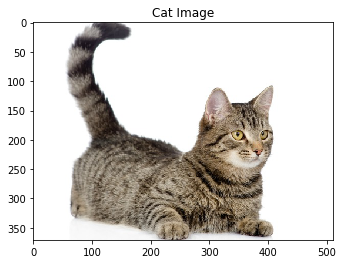

In [0]:
image_testing = load_image(content_path)
imshow(image_testing, 'Cat Image')

extractor_testing = StyleContentModel(style_layers, content_layers)
results = extractor_testing(tf.constant(image_testing), preprocess=True)
results_style = results['style']
results_content = results['content']

print('Style: ')
for layer, activation in results_style.items():
    print("\n     Layer: {}\n     Activation shape: {}".format(layer, activation.numpy().shape))

print()

print('Content: ')
for layer, activation in results_content.items():
    print("\n     Layer: {}\n     Activation shape: {}".format(layer, activation.numpy().shape))

As shown above, the extractor works properly.

The next step is to ***calculate the actual style and content losses*** with intermediate layer outputs and use it to update the output image ***z***.

In [0]:
def get_loss(outputs, target_style, target_content, weights=(1e2,7.5)):
    """ Inputs:
            outputs: output tensor of the extractor containing the style(gram matrices)
                and content activations of the image z.
            target_style: style activations(as gram matrices) of the style image, tensor.
            target_content: content activations of the content image, tensor.
            weights: scalars multiplying the style and content losses, tuple.
    Output: total loss
    """
    current_style, current_content = (outputs['style'],
                                      outputs['content'])

    style_weight, content_weight = weights

    style_loss = tf.add_n([tf.reduce_mean(tf.square(current_style[name] - target_style[name]))
                    for name in style_layers])
    style_loss *= style_weight/len(style_layers)
    
    content_loss = tf.add_n([tf.reduce_mean(tf.square(current_content[name] - target_content[name]))
                    for name in content_layers])
    content_loss *= content_weight/len(content_layers)

    loss = style_loss + content_loss
    return loss

@tf.function
def grads_and_loss_for_image(init_image, extractor, cfg):
    """ Inputs:
            init_image: Image z to be updated, tensor.
            extractor: Instance of the StyleContentModel() class.
            cfg: A Python diccionary that contains paramaters for
                get_loss().
    Function used to compute the gradients of the objective loss
    with respect to the pixel values of the generated image. Later
    these gradients are used to update the image z, minimizing the final
    loss.
    """
    with tf.GradientTape() as tape:
        outputs = extractor(init_image)
        loss = get_loss(outputs, **cfg)
        loss += tf.image.total_variation(init_image) * 30
    grads = tape.gradient(loss, init_image)
    return grads, loss

The **get_loss()** function computes the loss of the generated image at current iteration and it's used in **grads_and_loss_for_image()** to compute the gradients of the loss with respect to the pixel values of the image at each training step.

Notice here the content manager **tf.GradientTape()** is being used to perform **Autodiff**. The operations to be tracked must be contained inside this context manager, it automatically tracks the operations that each differentiable variable that Autodiff could perform. ***init_image*** must be a **tf.Variable()** tensor to perform differentiation.

The ***@tf.function*** decorator on ***grads_and_loss_for_image()*** is used to analyze the computations performed by the function and it generates a equivalent computation graph. As result, ***grads_and_loss_for_image()*** will be running much more efficient.

Having everything in place, now let's put them together to perform Style Transfer.

In [0]:
def load_and_preprocess_image(image_path):
    image = load_image(image_path)
    preprocessed = keras.applications.vgg19.preprocess_input(image)

    return preprocessed

def deprocess_image(processed_img):
    
    image = processed_img.copy()
    
    if len(image.shape) == 4:
        image = np.squeeze(image, axis=0)
    assert len(image.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(image.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    
    image[:,:,0] += 103.939
    image[:,:,1] += 116.779
    image[:,:,2] += 123.68
    image = image[:,:,::-1]
    
    image = np.clip(image, 0, 225).astype('uint8')
    return image

def run_nst(style_path, content_path, weights=(1e-2, 1e4), num_iters=500):
    print("Running Style Transfer...")
    
    style_image, content_image = (load_and_preprocess_image(style_path),
                                  load_and_preprocess_image(content_path))
    
    init_image = tf.Variable(content_image)

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']
    
    content_layers = ['block5_conv2']

    extractor = StyleContentModel(style_layers, content_layers)
    target_style = extractor(style_image)['style']
    target_content = extractor(content_image)['content']
    
    cfg = {
        'target_style': target_style,
        'target_content': target_content,
        'weights': weights
    }

    opt = keras.optimizers.Adam(lr=5, beta_1=0.99, epsilon=1e-1)

    image_means = np.array([103.939, 116.779, 123.68])
    min_values = - image_means
    max_values = 255.0 - image_means

    loss_evolution = []

    n_rows = 2
    n_cols = 5
    display_interval = num_iters/(n_rows*n_cols)

    best_loss, best_img = float('inf'), None

    images = []

    global_start = time.time()

    for i in range(1, num_iters+1):
        grads, loss = grads_and_loss_for_image(init_image, extractor, cfg)
        opt.apply_gradients([(grads, init_image)])
        init_image.assign(tf.clip_by_value(init_image, min_values, max_values))
        
        loss_evolution.append(loss)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_image(init_image.numpy())

        if i % display_interval == 0:
            plot_img = deprocess_image(init_image.numpy())
            images.append(plot_img)
    
    plt.figure(figsize=(14,4))
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title("Iteration: {}".format(int(i*display_interval)))
    
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    
    return best_loss, best_img, loss_evolution

Here we defined a helper function to deprocess the obtained image from Style Transfer. Like many other pre-trained models in ***tf.keras.applications***, VGG19 has its own preprocessing function(***tf.keras.applications.vgg19.preprocess_input***) to first manipulate the inputs before putting it into the model. In the case of VGG19(so does for VGG16), this preprocessing function turns the input image from RGB into BGR format and subtracts [103.939, 116.779, 123.68] respectively from each BGR channel. For this reason, once the image is obtained, a deprocessing step is required to add back these values and reverse the channels, hence  ***deprocess_image()***.

What ***run_nst()*** does is to run Neural Style Transfer by putting everything together. First, it loads and preprocesses the style and content image, and with the given style and content layers, we construct the extractor and compute the target style and content. In this case, instead of having the image ***z*** generated randomly, we use the content image and gradually update its pixel values so its style can mimic the one of the style image, it must be a ***tf.Variable*** tensor otherwise its pixel values won't be updated during training. The values of the image ***z*** must be clipped properly so they still range from [0, 255] when deprocessed.

The rest of it is self-explanatory. Inside the loop, it performs gradient and loss computation, applies the gradients with the defined optimizer and assigns the clipped values to the image. Losses are saved, and so are the images obtained during training. The function returns the image that has the lowest loss.

**Results:**

Running Style Transfer...
Total time: 25.3608s


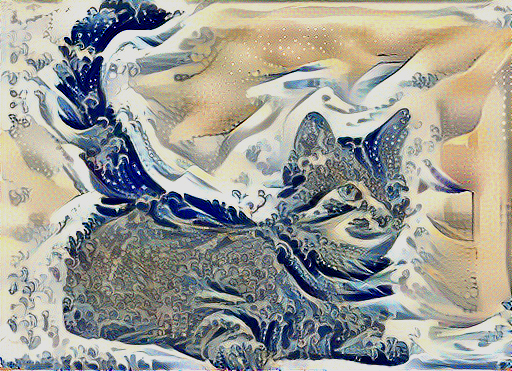

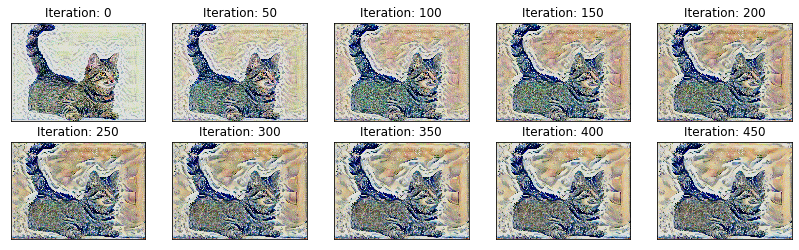

In [0]:
best_loss, result_image, losses = run_nst(style_path, content_path)
IPython.display.display_png(Image.fromarray(result_image))
target_path = '/content/images/result_image.jpg'
Image.fromarray(result_image).save(target_path)

Though we used 500 iterations, the results have shown that no significant changed were observed after 200 to 300 iterations. Taking a look at the loss evolution below, we could have iterated between 200 and 300 times and the result wouldn't have been much different.

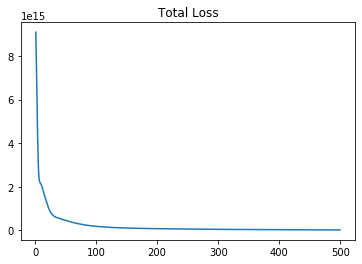

In [0]:
def plot_loss_evolution(losses):
    plt.plot(range(1, len(losses)+1), losses)
    plt.title('Total Loss')
plot_loss_evolution(losses)

# - Part 2
The part 2 of this notebook is dedicated to an intent of reproducing the results from [this paper](https://arxiv.org/abs/1603.08155), where instead of modifying the output image at each iteration as shown in part 1, the idea proposed this work suggest to train a model capable of transforming the style of any input into the desired one in ***real-time***. Such a model is capable of performing style transfer to obtain results similar to the baseline method by [Gatys et al](https://arxiv.org/abs/1508.06576)(Part 1), but up to ***three orders of magnitude faster***!

![Model Structure](https://user-images.githubusercontent.com/37034031/42068027-830719f4-7b84-11e8-9e87-088f1e476aab.png)

This figure from the literature illustrates the structure of the training process of such ***Image Transform Network(ITN)***. The model takes an image ***x*** as input and outputs a modified image ***y^***, then the content and style losses between this output and the given content(***yc***) and style(***ys***) targets are computed using a pre-trained model(***VGG16***). The input image here is the same as the content image.

*Johnson et al* trained the ITN on the [Microsoft COCO 2014 dataset](http://cocodataset.org/#home), each of the ***~80k*** images were resized to ***256x256***, the batch size used was ***4***, and the network was trained with only ***2 epochs*** over the training data(***~40,000 iteration***). A total variation regularization term was added with a strength ranging from [1e-6, 1e-4], the optimizer used was Adam with a ***learning rate*** of ***1e-3***.

The model's architecture consists of 3 downsampling layers, 5 residual blocks, and 3 upsampling layers so the outputs can have the same shape as the inputs.

The following block of code defines a model similar to the one employed in the literature.

Source: check [this repository.](https://github.com/lengstrom/fast-style-transfer/blob/master/src/transform.py)

In [0]:
def conv_layer(net, filters, kernel_size, strides, name,
               padding='SAME', relu=True,
               transpose=False):
    if not transpose:
        x = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                strides=strides, padding=padding,
                                name=name,
                                kernel_initializer=keras.initializers.TruncatedNormal(0, 0.1, 1))(net)
    else:
        x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                                         strides=strides, padding=padding,
                                         name=name,
                                         kernel_initializer=keras.initializers.TruncatedNormal(0, 0.1, 1))(net)
    
    x = tfa.layers.InstanceNormalization(axis=3,
                                         epsilon=1e-3,
                                         center=True,
                                         scale=True,
                                         beta_initializer='zeros',
                                         gamma_initializer='ones')(x)
    
    if relu:
        x = keras.activations.relu(x)
    
    return x

def residual_block(net, name_1, name_2):
    tmp1 = conv_layer(net, 128, 3, 1, name=name_1)
    
    return net + conv_layer(tmp1, 128, 3, 1, relu=False, name=name_2)

def NST_model(init_image):
    conv1 = conv_layer(init_image, 32, 9, 1, name='Conv1')
    conv2 = conv_layer(conv1, 64, 3, 2, name='Conv2')
    conv3 = conv_layer(conv2, 128, 3, 2, name='Conv3')
    resid1 = residual_block(conv3, name_1='resid1_in', name_2='resid1_out')
    resid2 = residual_block(resid1, name_1='resid2_in', name_2='resid2_out')
    resid3 = residual_block(resid2, name_1='resid3_in', name_2='resid3_out')
    resid4 = residual_block(resid3, name_1='resid4_in', name_2='resid4_out')
    resid5 = residual_block(resid4, name_1='resid5_in', name_2='resid5_out')
    conv_t1 = conv_layer(resid5, 64, 3, 2, transpose=True, name='ConvT1')
    conv_t2 = conv_layer(conv_t1, 32, 3, 2, transpose=True, name='ConT2')
    conv_t3 = conv_layer(conv_t2, 3, 9, 1, relu=False, name='ConT3')
    out = keras.activations.sigmoid(conv_t3) * 255.
    
    return out

def build_model():
    model_input = keras.Input(shape=(256, 256, 3), name='Input_layer')
    model_output = NST_model(model_input,)
    itn_model = keras.Model(model_input, model_output)
    return itn_model

In [0]:
itn_model = build_model()
itn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 7808        Input_layer[0][0]                
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 32) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 256, 256, 32 0           instance_normalization[0][0]     
____________________________________________________________________________________________

The model was originally trained on the [COCO dataset](https://www.tensorflow.org/datasets/catalog/coco), which has about 245K images in total(~80k training example). This is too large for GoogleColab to handle, since the dataset available in [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview) range from ***20 to 38 GiB***, downloading and prepraring the dataset requires a disk space as much as about 3x of its size.

Instead, we train on the [pet_finder dataset](https://www.tensorflow.org/datasets/catalog/pet_finder)(also available in TensorFlow Datasets). It contains images from 5 different classes of animals, with a total of ***~73k images***. The total number of iterations is about ***36k***.

Unlike part 1 of the notebook, the training of the model will be done in the traditional 'compile-fit' fashion - no customized training needed. However, a ***customized loss function*** is needed to compute the style and content losses between the model's output and the target images.

In [0]:
def style_content_loss(y_true, y_pred):
    outputs = extractor(y_pred, preprocess=True, model_mode=True)
    content_targets = extractor(y_true, preprocess=True, model_mode=True)['content']
    loss = get_loss(outputs, style_targets, content_targets, weights=(1e-2, 7.5e9))
    loss += tf.image.total_variation(y_pred) * 2e2
    return loss

Defining a customized loss function in TensorFlow 2.0 is as easy as it gets. The function takes two parameters: ***y_true*** and ***y_pred***. The first one is the typical 'y_train' and y_pred is the model's output.

Inside this loss function, we'd use the ***extractor*** defined as before to extract y_pred's style and content activation and y_true's content activations only. We later use them together with the style target to get the total loss.

A ***total variation loss*** term is added be secure the smoothness of the output images.

In [0]:
# Several helper functions defined here for dataset preprocessing
# and model testing after training.

def view_image_examples(dataset):
    """Function to plot 10 images from the given dataset
    """
    i = 0
    plt.figure(figsize=(12, 4))
    for item in dataset.take(6):
        i+=1
        plt.subplot(2,3,i)
        plt.imshow(item['image'])
        plt.xticks([])
        plt.yticks([])

IMG_SIZE = 256

def resize_images(images):
    """Normalize pixels and resize images"""

    images = tf.cast(images, tf.float32)
    images = tf.divide(images, 255.)
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))
    return images

def preprocess_dataset(dataset):
    dataset = dataset.map(lambda item: item['image'])
    dataset = dataset.map(resize_images)
    dataset = dataset.map(lambda item: (item, item))
    dataset_xy = dataset.shuffle(10000).batch(4).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset_xy

def test_the_model(num, dataset, model):
    for item in dataset.take(num):
        image = item['image']
    image = resize_images(image)
    image_testing = model(tf.expand_dims(image, 0))
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.imshow(image.numpy())

    plt.subplot(1,2,2)
    imshow(image_testing.numpy())

We download the ***pet_finder dataset*** from TensorFlow Datasets. Like most of its datasets, its split into different subsets, we use ***dataset.concatenate()*** to merge the subsets together.

In [0]:
dataset = tfds.load(name='pet_finder')

pet_train, pet_test = dataset['train'], dataset['test']
pet_combine = pet_train.concatenate(pet_test)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/pet_finder/1.0.0.incomplete3L93KK/pet_finder-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/pet_finder/1.0.0.incomplete3L93KK/pet_finder-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset pet_finder downloaded and prepared to /root/tensorflow_datasets/pet_finder/1.0.0. Subsequent calls will reuse this data.


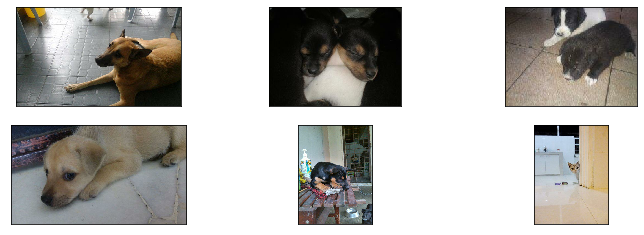

In [0]:
# Take a peak at the images
view_image_examples(pet_combine)

In [0]:
# Preprocess the dataset so each element of it is a tuple
# containing x_train and y_train, which in this case are the
# both the same image yc.
pet_xy = preprocess_dataset(pet_combine)
pet_xy.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))

Now let's train the model. First, we need to define the ***extractor*** and the ***style target*** for the loss function.

We use ***Adam*** as the optimizer and we save the model weights at each epoch using the ***CheckPoint Callback***.

In [0]:
style_image = load_image(style_path, size=256)

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image, preprocess=True, model_mode=True)['style']

opt = keras.optimizers.Adam(lr=1e-3)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

itn_model = build_model()
itn_model.compile(optimizer=opt, loss=style_content_loss)
itn_model.fit(pet_xy, epochs=2, callbacks=[cp_callback])
# first training, using weights=(1e2, 7.5)
# all the content features are gone.

Epoch 1/2
  18194/Unknown - 2539s 140ms/step - loss: 250044559734.3898
Epoch 00001: saving model to training_1/cp.ckpt
18194/18194 [==============================] - 2539s 140ms/step - loss: 250044559734.3898
Epoch 2/2
18193/18194 [============================>.] - ETA: 0s - loss: 22561726364.9940
Epoch 00002: saving model to training_1/cp.ckpt
18194/18194 [==============================] - 2535s 139ms/step - loss: 22561465485.7751


After training for ***2 epochs***, the results shown aren't as expected: The style seems to be transferred successfully but no contents are captured whatsoever.

We can only appreciate some small differences when comparing the results of different images, as shown below.

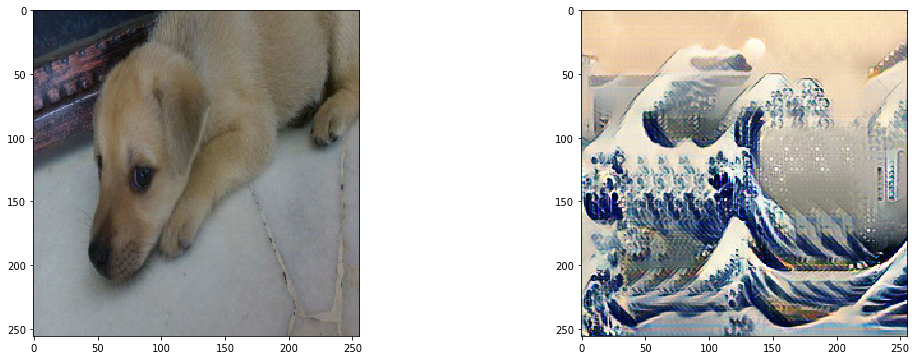

In [0]:
# testing after 2 epochs
test_the_model(4, pet_train, itn_model)

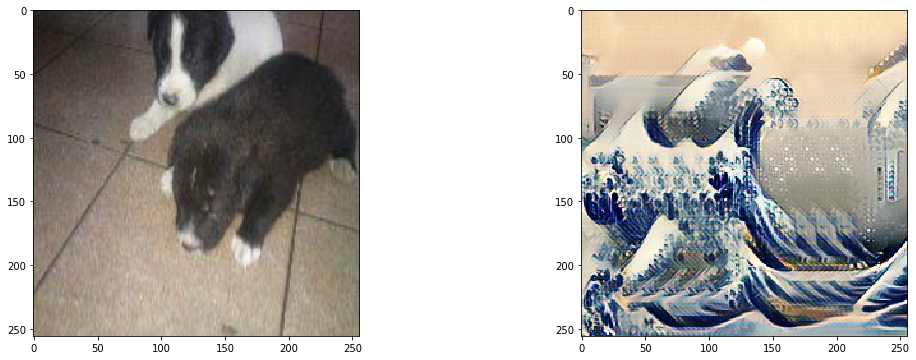

In [0]:
test_the_model(3, pet_train, itn_model)

The first idea that occurred to me was to increase the content loss weight to help the model to put more emphasis on assimilating the content of its inputs.

Increasing the content loss weight by 4 orders of magnitude(7.5 -> 7.5e4) did not seem to help, neither does a 9 order of magnitude increase(7.5 -> 7.5e9).

In [0]:
# Train to model for only one epoch, increasing its content loss weight to 7.5e4

style_image = load_image(style_path, size=256)

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image, preprocess=True, model_mode=True)['style']

opt = keras.optimizers.Adam(lr=1e-3)

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

itn_model_1 = build_model()
itn_model_1.compile(optimizer=opt, loss=style_content_loss)
itn_model_1.fit(pet_xy, epochs=1, callbacks=[cp_callback])

  18194/Unknown - 2547s 140ms/step - loss: 253658389048.1134
Epoch 00001: saving model to training_2/cp.ckpt
18194/18194 [==============================] - 2548s 140ms/step - loss: 253658389048.1134


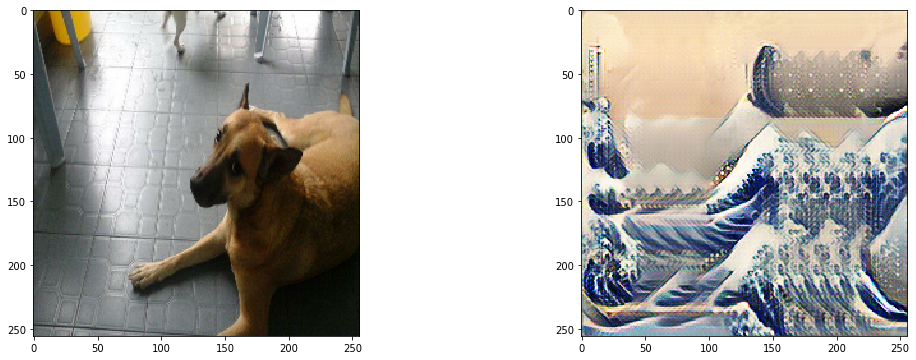

In [0]:
test_the_model(1, pet_train, itn_model_1)

In [0]:
# Train to model for only one epoch, increasing its content loss weight to 7.5e9

style_image = load_image(style_path, size=256)

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image, preprocess=True, model_mode=True)['style']

opt = keras.optimizers.Adam(lr=1e-3)

checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

itn_model_2 = build_model()
itn_model_2.compile(optimizer=opt, loss=style_content_loss)
itn_model_2.fit(pet_xy, epochs=1, callbacks=[cp_callback])

# new_model = build_model()
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# new_model.load_weights(latest)

  18194/Unknown - 2517s 138ms/step - loss: 1439831865398.2561
Epoch 00001: saving model to training_3/cp.ckpt
18194/18194 [==============================] - 2518s 138ms/step - loss: 1439831865398.2561


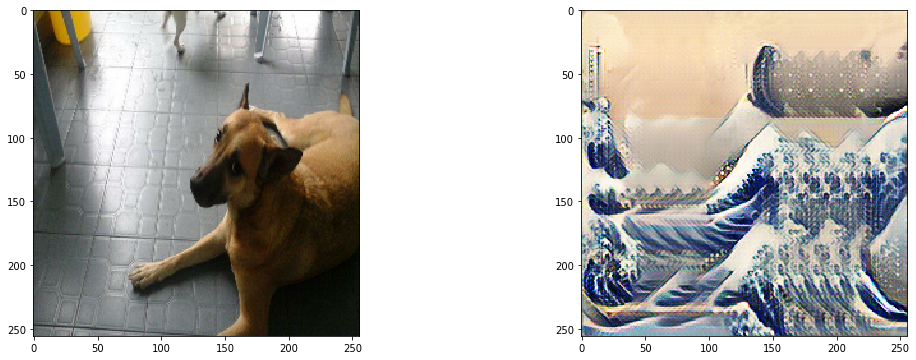

In [0]:
test_the_model(1, pet_train, itn_model_1)

The second part ends here with an unsuccessful intent training an ITN for stylization in real-time. The conclusion is that though the style can be 'transferred' with somewhat success, the content of the input image is completely ignored by the model.

I tried to address the issue by increasing the content loss weight expecting the model to put more emphasis on maintaining the features from the input image, but it was unsuccessful.

# Conclusions

In this notebook, efforts were split into two parts to better understand Neural Style Transfer. Part 1 consists of performing style transfer following the guideline set by Gatys et al in their studies. Though it closely follows a tutorial from TensorFlow's website, every part of the code was well studied and completely understood. At the end of it, I furthered my understanding of how to writing reusable code, customizing training loops, how to use transfer learning, and a better understanding of TensorFlow 2.0 in general.

The second part was more difficult to do in comparison with the first one, although many people have done it before, there weren't any explicit resources to be found to address many of the problems encountered. Although I wasn't able to achieve the goals I set initially, I still learned many things from it:

1. How to customized loss functions.
2. Use TensorFlow's Callbacks to save model weights in case of training interruptions occur.
3. Finding and preprocessing datasets.

More efforts could've been put into overcoming the final obstacle but obviously, it would take much more time - try more combinations of hyperparameters, change the intermediate layers, try different datasets, find out more insights from research papers, etc. But as a personal project that it is, I believe I have obtained the most of what it has to offer.